# 对抗示例生成

[![](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/source_zh_cn/middleclass/image_and_video/adversative_nets_mark.ipynb)

以往机器学习模型的研究方向多数在高效、准确等方面。模型的安全性和鲁棒性被经常性地忽略，特别是在面对攻击时，模型易被欺骗的现象表现得尤为明显。

本教程将讨论机器学习模型的安全漏洞，并深入了解对抗性机器学习这一热门话题。我们会通过图像分类的示例，展示出在图像上添加无法察觉的扰动之后，模型表现也会完全不同。扰动方式将使用梯度攻击来完成。 

## 威胁模型

就上下文而言，有多种类型的对抗性攻击，每种攻击者的目标和假设都不同。但是，总的来说，总体目标是向输入数据添加最少的扰动，以引起所需的错误分类。攻击者的知识有几种假设，其中两种是：**白盒**和**黑盒**。*白盒*攻击假定攻击者具有完全的知识并可以访问模型，包括架构，输入，输出和权重。*黑盒*攻击假定攻击者只能访问模型的输入和输出，并且对底层架构或权重一无所知。目标也有几种类型，包括**错误分类**和**源/目标错误分类**。*错误分类*意味着对手只希望输出分类错误，而不在乎新分类是什么。*源/目标错误分类*意味着对手想要更改最初属于特定源类别的图像，以便将其分类为特定目标类别。

在这种情况下，本实验采用白盒方式攻击，其实验目标是*错误分类*。有了这些背景信息，我们现在可以详细讨论攻击了。

## 梯度符号攻击

迄今为止，最早的也是最流行的对抗性攻击之一被称为*梯度符号攻击（FGSM）*，由[《解释和利用对抗性示例》](https://arxiv.org/abs/1412.6572) （Goodfellow 等）描述。攻击非常强大，而且直观。它旨在利用神经网络学习*梯度*的方式来攻击神经网络。这个想法很简单，不是通过基于反向传播的梯度来调整权重来使损失最小化，攻击会基于相同的反向传播的梯度来调整输入数据，以使损失最大化。换句话说，攻击使用损失相对于输入数据的梯度，然后调整输入数据以使损失最大化。

在执行代码之前，让我们看一下著名的 [FGSM](https://arxiv.org/abs/1412.6572) Pandas 示例，并介绍一些参数。

![fgsm-panda-image](images/panda.png)

- $x$：正确分类为“Pandas”的原始输入图像。
- $y$：是$x$的输出。
- $\theta$：模型参数。
- $J(\theta, x, y)$：训练网络的损失。
 
攻击会将梯度反向传播回输入数据，以计算$\nabla_x J(\theta ,x ,y)$。然后，它会沿方向（即$\nabla_x  J(\theta)$）的一小步（图片中的$\epsilon$-0.007）调整输入数据，使损失最大化。最后，当目标图像仍明显是“Pandas”时，目标网络将它们误分类为“长臂猿”。

现在开始准备实现梯度攻击：

In [1]:
# 导入模型训练需要的库
import os
import mindspore
import numpy as np
from mindspore import Tensor
import mindspore.nn as nn
import mindspore.ops as ops
import matplotlib.pyplot as plt
from mindspore.common.initializer import Normal
import argparse
from mindspore import context
from mindspore.nn import Accuracy
from mindspore.train.callback import LossMonitor
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV
from mindspore.dataset.vision import Inter
from mindspore import dtype as mstype
from mindspore import Model
from mindspore.nn import TrainOneStepCell
from mindspore.ops import composite as com
from mindspore import load_checkpoint, load_param_into_net
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig

## 实现

在本节中，我们将讨论本教程的输入参数，定义受到攻击的模型，然后编写攻击代码并运行一些测试。

### 输入

本教程的输入参数主要为`epsilons`：

- `epsilons`- 指用于运行的$\epsilon$值列表。$\epsilon$为0时表示原始测试集上的模型表现。$\epsilon$值越大，扰动越明显，对模型准确率的攻击也越有效。实验中设定取值范围为0～1.3。

In [2]:
epsilons = [0, 0.2, 0.5, 0.7, 1.0, 1.3]

下面配置运行所需要的信息

In [3]:
parser = argparse.ArgumentParser(description='MindSpore LeNet Example')
parser.add_argument('--device_target', type=str, default="CPU", choices=['Ascend', 'GPU', 'CPU'])
args = parser.parse_known_args()[0]
context.set_context(mode=context.GRAPH_MODE, device_target=args.device_target)

### 受到攻击的模型

实验中使用LeNet作为演示模型，采用MINIST数据集。这里先对模型进行训练，后对符合精度要求的模型采去攻击操作。

定义LeNet网络：

In [4]:
class LeNet5(nn.Cell):

    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

net = LeNet5()

下载MINIST数据集：

In [5]:
!mkdir -p ./datasets/MNIST_Data/train ./datasets/MNIST_Data/test
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-labels-idx1-ubyte
!wget -NP ./datasets/MNIST_Data/train https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/train-images-idx3-ubyte
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-labels-idx1-ubyte
!wget -NP ./datasets/MNIST_Data/test https://mindspore-website.obs.myhuaweicloud.com/notebook/datasets/mnist/t10k-images-idx3-ubyte
!tree ./datasets/MNIST_Data

./datasets/MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte

2 directories, 4 files


进行数据处理：

In [6]:
def create_dataset(data_path, batch_size=1, repeat_size=1,
                   num_parallel_workers=1):
    mnist_ds = ds.MnistDataset(data_path)
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

    resize_op = CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=resize_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=rescale_nml_op, input_columns="image", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=hwc2chw_op, input_columns="image", num_parallel_workers=num_parallel_workers)

    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)

    return mnist_ds

定义优化器与损失函数：

In [7]:
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(net.trainable_params(), learning_rate=0.01, momentum=0.9)

设置并应用模型保存参数：

In [8]:
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)

定义测试和训练网络：

In [9]:
def test_net(model, data_path):
    ds_eval = create_dataset(os.path.join(data_path, "test"))
    acc = model.eval(ds_eval, dataset_sink_mode=False)
    print("{}".format(acc))
    
def train_net(model, epoch_size, data_path, repeat_size, ckpoint_cb, sink_mode):
    ds_train = create_dataset(os.path.join(data_path, "train"), 32, repeat_size)
    model.train(epoch_size, ds_train, callbacks=[ckpoint_cb, LossMonitor(125)], dataset_sink_mode=sink_mode)

进行预模型训练并加载到网络中：

In [10]:
train_epoch = 1
mnist_path = "./datasets/MNIST_Data/"
dataset_size = 1
model = Model(net, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
train_net(model, train_epoch, mnist_path, dataset_size, ckpoint, False)
test_net(model, mnist_path)
param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
load_param_into_net(net, param_dict)

epoch: 1 step: 125, loss is 2.2934856
epoch: 1 step: 250, loss is 2.2901366
epoch: 1 step: 375, loss is 2.2859986
epoch: 1 step: 500, loss is 2.2872832
epoch: 1 step: 625, loss is 2.299801
epoch: 1 step: 750, loss is 2.2765894
epoch: 1 step: 875, loss is 0.9849755
epoch: 1 step: 1000, loss is 0.29427448
epoch: 1 step: 1125, loss is 0.8494657
epoch: 1 step: 1250, loss is 0.30428752
epoch: 1 step: 1375, loss is 0.20079668
epoch: 1 step: 1500, loss is 0.14930087
epoch: 1 step: 1625, loss is 0.0818441
epoch: 1 step: 1750, loss is 0.1273436
epoch: 1 step: 1875, loss is 0.096194
{'Accuracy': 0.9345}


### 梯度攻击

现在，我们干扰原始输入并定义攻击函数`attack`。`attack`函数接受三个输入，`image`是原始的干净图像（$x$），`epsilon`是像素级扰动量$\epsilon$，`data_grad`是输入图像损失的梯度（$\nabla_x J(\theta ,x ,y)$）。该函数然后创建扰动图像为

 $$
 perturbed\_image = image + epsilon \times sign(data\_grad) = x + \epsilon \times sign(\nabla_x J(\theta ,x ,y))
 $$

最后，为了维持数据的原始范围，将被扰动的图像裁剪到范围`[0,1]`。

定义攻击方法。

In [11]:
def attack(image, epsilon, data_grad):
    sign = ops.Sign()
    sign_data_grad = sign(data_grad)
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = mindspore.ops.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image
net_with_criterion = nn.WithLossCell(net, net_loss)
fin_train_net = TrainOneStepCell(net_with_criterion, net_opt)

### 测试函数

本教程的主要结果来自`test`函数。每次调用此测试函数都会在 MNIST 测试集上执行完整的测试步骤，并报告最终精度。`test`函数中还需要`epsilon`输入来控制攻击的强弱变化。

In [12]:
def test(net, ds_test, epsilon):
    net_with_criterion = nn.WithLossCell(net, net_loss)
    # 使用Model接口包装模型
    pre_model = Model(net, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
    # 计算过程变量初始化
    correct = 0
    incorrect = 0
    num = 0
    for data in ds_test:
        image = data["image"].asnumpy()
        label = data["label"].asnumpy()
        image_tensor = Tensor(data['image'])
        label_tensor = Tensor(data['label'])
        pre_output = pre_model.predict(image_tensor)
        predicted = np.argmax(pre_output.asnumpy(), axis=1)
        if predicted[0] != label[0]:
            num += 1
            continue 
        num += 1
        pre_loss = net_with_criterion(image_tensor, Tensor(data['label']))
        grad = com.GradOperation()
        grads = grad(net_with_criterion)(image_tensor, Tensor(data['label']))
        perturbed_data = attack(Tensor(data['image']), epsilon, grads)
        final = pre_model.predict(perturbed_data)
        fin_predicted = np.argmax(final.asnumpy(), axis=1)
        if fin_predicted[0] == label[0]:
            correct += 1
        if fin_predicted[0] != label[0]:
            incorrect += 1
    final_acc = correct / (correct + incorrect)
    print ("Accuracy = ", final_acc)
    return final_acc 

### 运行攻击

实验的最后一部分是实际运行攻击。在这里，我们为`epsilon`输入中的每个$\epsilon$值运行完整的测试步骤。$\epsilon = 0$表示没有受到攻击时的原始测试准确率，并且随着$\epsilon$的增大，精度在逐渐下降。


In [13]:
accuracies = []
# 定义测试数据集，batch_size=1表示每次取出一张图片
ds_test = create_dataset(os.path.join(mnist_path, "test"), batch_size=1).create_dict_iterator()
for eps in epsilons:
    final_acc = test(net, ds_test, eps)
    accuracies.append(final_acc)
    print ("eps = ", eps, "Accuracy = ", final_acc)

Accuracy =  0.9602996254681648
eps =  0 Accuracy =  0.9602996254681648
Accuracy =  0.9250936329588015
eps =  0.2 Accuracy =  0.9250936329588015
Accuracy =  0.8088817549491707
eps =  0.5 Accuracy =  0.8088817549491707
Accuracy =  0.5854467629748529
eps =  0.7 Accuracy =  0.5854467629748529
Accuracy =  0.23542001070090957
eps =  1.0 Accuracy =  0.23542001070090957
Accuracy =  0.09898341359015517
eps =  1.3 Accuracy =  0.09898341359015517


## 结果分析

### 准确率与$\epsilon$

第一个结果是精度与$\epsilon$曲线的关系。如前所述，随着$\epsilon$的增加，我们预计测试精度会降低。这是因为更大的$\epsilon$意味着我们朝着将损失最大化的方向迈出了更大的一步。请注意，即使$\epsilon$值是线性间隔的，曲线中的趋势也不是线性的。可以看出，Eps越大，Accuracy的下降幅度就越大。在Eps为0时，测试集拥有98%左右的精确度，但当Es增大为1以上时，模型几乎无法识别图像。

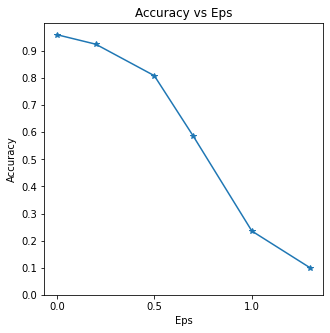

In [14]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.0, step=0.1))
plt.xticks(np.arange(0, 1.5, step=0.5))
plt.title("Accuracy vs Eps")
plt.xlabel("Eps")
plt.ylabel("Accuracy")
plt.show()

攻击前后数据集图片效果如下图，左侧为原始样本，右侧为梯度攻击后生成的对抗样本。从视觉角度而言，右侧图片与左侧图片几乎没有明显变化，但是均成功误导了模型，使模型将其误分类为其他非正确类别。

![attack-result](images/attack_result.png)